In [1]:
%matplotlib inline
import os
import math
import shutil
import pickle
import random
import tensorflow as tf
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

import IPython.display as ipd

import librosa
from librosa.display import specshow

from IPython.display import Audio

In [2]:
# check permissions
# read
DATA_FOLDER = '/projects/data/data_v_7_stc'
METAFOLDER = os.path.join(DATA_FOLDER, 'meta')
METAFILE = os.path.join(METAFOLDER, 'meta.txt')
AUDIO_FOLDER = os.path.join(DATA_FOLDER, 'audio')

# write
REFINED_FOLDER = os.path.join(DATA_FOLDER, 'refined', '')
REFINED_META = os.path.join(METAFOLDER, 'refined_meta.txt')

In [3]:
df = pd.read_csv(METAFILE, sep='\t', header=None)
df.columns = ['file', 'unk1', 'unk2', 'duration', 'type']

In [4]:
df.sample(5)

,file,unk1,unk2,duration,type
2767,door_0029_time_stretch_9.wav,office,0,4.648980,door
9940,tool_0293.wav,office,0,1.110000,tool
11257,tool_1610.wav,office,0,1.248625,tool
5759,t_door_0089_time_stretch_5.wav,office,0,2.674921,door
4729,d_0097_time_stretch_0.wav,office,0,0.556599,door


# Find file count of each type

In [5]:
rows_count = lambda df, t: len(df.loc[df['type'] == t].index)
type_freqs = {name: rows_count(df, name) for name in df['type'].unique()}

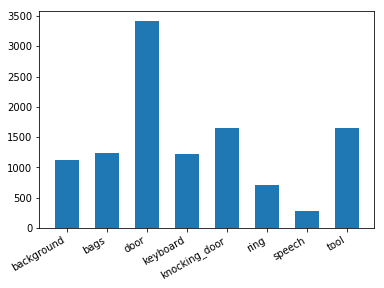

In [6]:
plt.bar(range(len(type_freqs)), list(type_freqs.values()), align='center', width=0.6)
plt.xticks(range(len(type_freqs)), list(type_freqs.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right') 
 
plt.show()

# Find average durations

In [34]:
avg_duration = lambda df, t: df.loc[df['type'] == t]['duration'].mean()
type_avg_durations = {name: avg_duration(df, name) for name in uniqs}

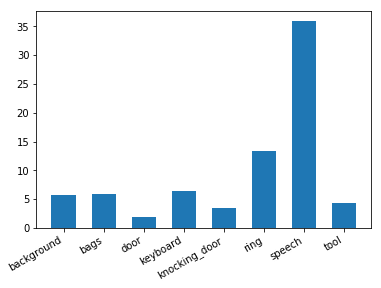

In [35]:
plt.bar(range(len(type_avg_durations)), list(type_avg_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_avg_durations)), list(type_avg_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Find total durations

In [36]:
total_duration = lambda df, t: df.loc[df['type'] == t]['duration'].sum()
type_durations = {name: total_duration(df, name) for name in uniqs}

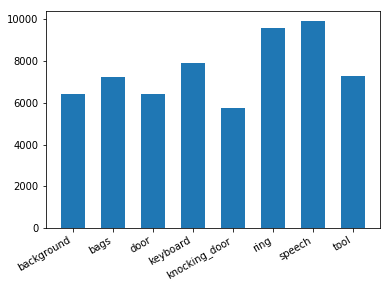

In [37]:
plt.bar(range(len(type_durations)), list(type_durations.values()), align='center', width=0.6)
plt.xticks(range(len(type_durations)), list(type_durations.keys()))
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()

# Analyze sounds

### Histogram of file durations

Text(0.05, 0.5, 'file count')

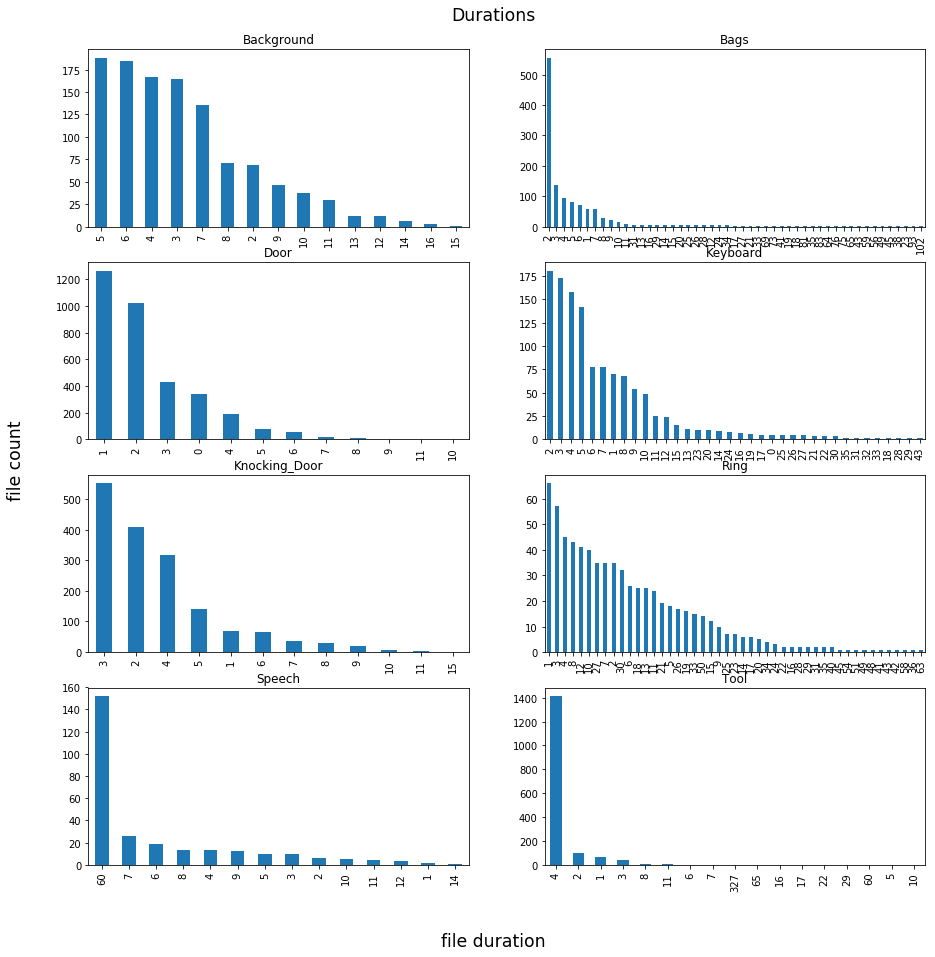

In [38]:
temp_df = pd.DataFrame()
temp_df['duration'] = df['duration'].map(lambda x: round(x))
temp_df['type'] = df['type']

fig, ax_rows = plt.subplots(nrows=4, ncols=2, figsize=(15,15))

axes = [ax for row in ax_rows for ax in row]
types = temp_df['type'].unique()

for typ, ax in zip(types, axes):
    ax.set_title(typ.title(), fontsize='large')
    temp_df.loc[temp_df['type'] == typ]['duration'].value_counts().plot(kind='bar', ax=ax)

# set title and axis labels
plt.suptitle('Durations', y=0.92, ha='center', fontsize='xx-large')
fig.text(0.5, 0.05, 'file duration', ha='center', fontsize='xx-large')
fig.text(0.05, 0.5, 'file count', va='center', rotation='vertical', fontsize='xx-large')

# Process data

## Pickle features

In [86]:
from processing.extractor import FeatureExtractor
from model.batcher import Batcher
from model.config import Config
from model.model import Model

In [88]:
config = Config()
extractor = FeatureExtractor(config)
out_path = os.path.join(DATA_FOLDER, 'features.pickle')

In [ ]:
features = []
shuffled_df = df.sample(frac=1)
shuffled_df = pd.get_dummies(shuffled_df, columns=['type'])

for _, row in tqdm(shuffled_df.iterrows()):
    file = row['file']
    filepath = os.path.join(AUDIO_FOLDER, file)
    log_mels = extractor.reshape(extractor.get_mels(filepath))
    feats.append({
        'file': file,
        'type': row.values[4:].astype(int),
        'log_mel': log_mels,
    })
    
with open(out_path, 'wb') as f:
    pickle.dump(feats, f)    

In [10]:
with open(out_path, 'rb') as f:
    feats = pickle.load(f)

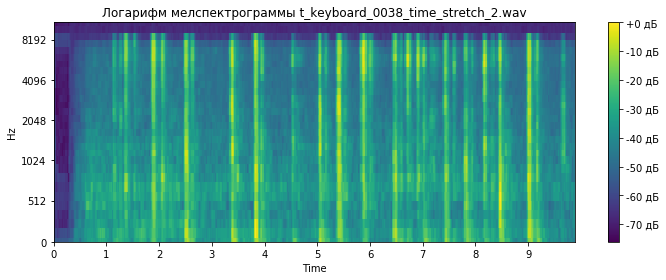

In [13]:
n = random.randint(0, len(feats))
plt.figure(figsize=(10, 4))
specshow(feats[n]['log_mel'], y_axis='mel',
         fmax=SAMPLE_RATE//2, x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f дБ')
plt.title('Логарифм мелспектрограммы {}'.format(feats[n]['file']))
plt.tight_layout()
plt.show()

Audio(filename=os.path.join(AUDIO_FOLDER, feats[n]['file']))

In [15]:
prepare_shape(feats[0]['log_mel'], config).shape

(30, 64, 1)

In [17]:
[f['type'] for f in feats]

[array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 1, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 1, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 1, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 1]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 1, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 1, 0, 0, 0, 0]),
 array([0, 0, 

# Create smth for ml

### 0) load dataframe

### 1) shuffle dataframe and create categorical column for type

In [4]:
refined_df = refined_df.sample(frac=1).reset_index(drop=True)

In [5]:
refined_df.type = pd.Categorical(refined_df.type)
refined_df['code'] = refined_df.type.cat.codes

### 2) create train data generator

In [56]:
from keras.utils import Sequence


class Batcher(Sequence):
    def __init__(self, data, batch_size=40):
        self.batch_size = batch_size
        self.x = np.array([prepare_shape(f['log_mel'], config)  for f in data])
        self.y = np.array([f['type'] for f in data])
        self.indexes = np.arange(len(data))
        
    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))
    
    def __getitem__(self, index):
        indexes_tmp = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        res_x = self.x[indexes_tmp]
        res_y = self.y[indexes_tmp]
        return res_x, res_y


### 3) Create, compile, train model (не работает)

In [81]:
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D

# конфиг:
# - 2 слоя Conv2D
# - слой Flatten
# - 2 слоя Dense
# - активационная функция softmax

model = Sequential([
    Conv2D(16, kernel_size=(4, 4), input_shape=config.shape),
    Conv2D(16, kernel_size=(4, 4)),
    Flatten(),
    Dense(16),
    Dense(8),
    Activation('softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

threshold = int(len(feats)*0.8)
model.fit_generator(Batcher(feats[:threshold]),
                    validation_data=Batcher(feats[threshold:]),
                    steps_per_epoch=50, epochs=30, verbose=1)

Epoch 1/30
50/50 [==============================] - 7s 140ms/step - loss: 11.5544 - acc: 0.2794 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 2/30
50/50 [==============================] - 9s 175ms/step - loss: 11.2307 - acc: 0.3032 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 3/30
50/50 [==============================] - 9s 181ms/step - loss: 11.4590 - acc: 0.2891 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 4/30
50/50 [==============================] - 9s 179ms/step - loss: 11.4698 - acc: 0.2884 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 5/30
50/50 [==============================] - 9s 180ms/step - loss: 10.8979 - acc: 0.3239 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 6/30
50/50 [==============================] - 9s 177ms/step - loss: 11.0019 - acc: 0.3174 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 7/30
50/50 [==============================] - 9s 176ms/step - loss: 11.0123 - acc: 0.3168 - val_loss: 11.2941 - val_acc: 0.2993
Epoch 8/30
50/50 [==============================] - 9s 176ms/s

In [82]:
model.history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

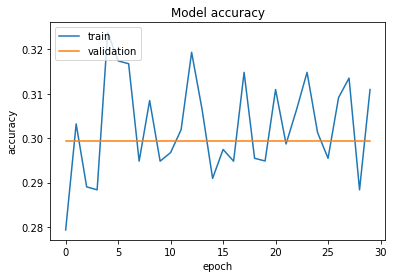

In [83]:
plt.plot(model.history.history['acc'])
plt.plot(model.history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

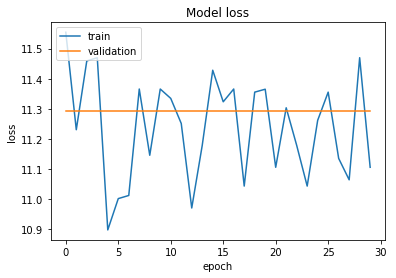

In [84]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()